In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import math
import time
from scipy import ndimage
#import edge_detection from edge_detectionhttp://localhost:8888/notebooks/332_FP/Image%20Object%20and%20Rotation%20Workspace.ipynb#
from read_image import image_read

In [32]:
class Piece:
    def _init_(color, rot_arr):
        
        #rot_arr: -1  = inward piece
        #          0  = flat edge
        #          1  = outward piece
        #first cell is top edge, next continues clockwise
        #
        self.color = color
        self.rot_arr = rot_arr
        self.edges = edge_detection(color, 50, 150)
        
        zero_count = 0 
        for x in range(len(rot_arr)):
            if(rot_arr[x] == 0):
                zero_count += 1
                
        if(zero_count == 2):
            self.typ = "corner"
        elif(zero_count == 1):
            self.typ  = "edge"
        else:
            self.typ = "inner"    
        
    
def rotate(img):
        rows,cols = img.shape
        M = cv.getRotationMatrix2D((cols/2,rows/2),-90,1)
        dst = cv.warpAffine(img,M,(cols,rows))  
            
        return dst

In [ ]:
t = image_read("test.bmp")
plt.imshow(t, cmap = plt.get_cmap('gray'))
plt.show()

tn = rgb2gray(t)
new = rotate(tn)
plt.imshow(new, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
newt = cv.Canny(tn,100,200)
plt.show()

In [ ]:
tn = rgb2gray(t)

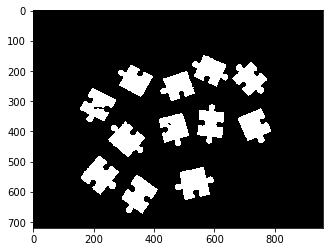

In [33]:
def thresholding_morph(filename):
    t = image_read(filename)
    #t =  t[750:1750,750:1750,:]
    tn = cv.cvtColor(t,cv.COLOR_BGR2GRAY)
    dim = tn.shape

    for x in range(dim[0]):
        for y in range(dim[1]):
            if(tn[x,y]>40):
                tn[x,y] = 255
            else:
                tn[x,y] = 0
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(3,4))
    closing = cv.morphologyEx(tn, cv.MORPH_CLOSE, kernel)
    opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)
    return opening

In [37]:
def CCL(file):
    
    def find_min(e_table, number):
        t = np.where(e_table[number] == 1)
        return t[0][0]

    #Pass 1
    img = file
    I = img[:,:]/(255)
    I = I.astype(int)

    dim = list(I.shape)
    newimg = np.zeros(dim)
    newimg = newimg.astype(int)
    e_table = np.identity(4500)
    L=1

    for row in range(dim[0]):
        for col in range(dim[1]):
            pixel = I[row,col]
            if(pixel == 1):
                upper = newimg[row-1,col]
                left = newimg[row,col-1]
                if(upper == 0):
                    if(left == 0):
                        newimg[row,col] = L
                        L+=1
                    else:
                        newimg[row,col] = max(left,upper)
                if(upper != 0):
                    if(left == 0):
                        newimg[row,col] = max(left,upper)
                    elif(left == upper):
                        newimg[row,col] = upper
                    else:
                        newimg[row,col] = min(left,upper)
                        e_table[max(left,upper)][min(left,upper)] = 1


    #Pass 2
    for u in range(dim[0],0,-1):
        t = np.where(e_table[u] == 1)
        p = t[0][0]
        newimg[np.where(newimg == u)] = p
        
    #Size Filtration
    uni = []
    for u, row in enumerate(newimg):
        for v, pixel in enumerate(row):
            if pixel not in uni and pixel != 0:
                uni.append(pixel)

    u,counts = np.unique(newimg, return_counts = True)
    ucount = np.asarray((u, counts)).T

    remove = []
    for idx, count in enumerate(counts):
        if count < 10:
            remove.append(u[idx])

    for u, row in enumerate(newimg):
        for v, pixel in enumerate(row):
            if pixel != 0 and pixel in remove:
                newimg[u][v] = 0

    for rowID in range(len(img)):
        for colID in range(len(img[0])):
            img[rowID][colID] = (newimg[rowID][colID]*70)%255
            

    plt.imshow(img)
    plt.show()
    return newimg,len(np.unique(newimg)-1)


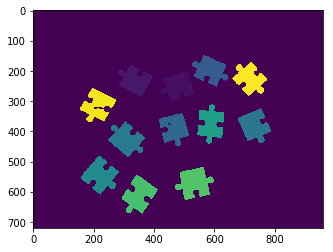

In [38]:
t=CCL(opening)

In [29]:
np.savetxt("labeled_adam.csv", t[0], delimiter=",")

In [31]:
t[0].shape

(720, 960)

In [ ]:
tn[0,0]= 256

In [39]:
gray = cv.cvtColor(t,cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap = plt.get_cmap('gray'))
plt.show()

TypeError: src is not a numerical tuple

In [35]:
max(gray[0])

36

ValueError: Colormap 13 is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

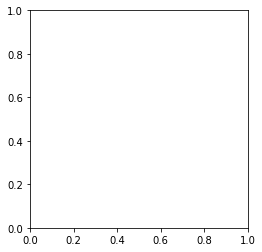

In [40]:


ret, labels = cv.connectedComponents(opening, connectivity = 8)

# Map component labels to hue val
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

plt.imshow('labeled.png', ret)
plt.show()

In [ ]:
opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel)
plt.imshow(opening, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
plt.imshow(tn, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
kernel = cv.getStructuringElement(cv.MORPH_RECT,(20,20))
closing = cv.morphologyEx(tn, cv.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap = plt.get_cmap('gray'))
plt.show()